#**Ch3. 분류**


##**3.1 MNIST**
고등학생과 미국 인구조사국 직원들이 손으로 쓴 70000개의 작은 숫자 이미지를 모은 MNIST 데이터셋



In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784',version=1,as_frame= False)
mnist.keys()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

<사이킷런의 데이터셋 구조>
- 데이터셋을 설명하는 DESCR 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
- 레이블 배열을 담은 target 키

In [2]:
X,y = mnist['data'], mnist['target']
X.shape
# y.shape

(70000, 784)

이미지가 70000개, 각 이미지에 784개의 특성
- 특성 : 0(흰색)~255(검은색)의 픽셀강도

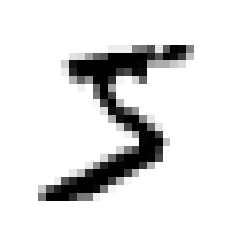

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [5]:
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

##**3.2 이진 분류기 훈련**
'5-감지기' : 숫자 5만 식별하는 **이진 분류기**

In [7]:
#분류 작업을 위한 타깃 벡터
y_train_5 = (y_train==5) #5는 True, 다른 숫자는 모두 False
y_test_5 = (y_test==5)

사이킷런의 SGDClassifier - 확률적 경사 하강법(Stochastic Gradient Descent)분류기
- 매우 큰 데이터셋을 효율적으로 처리함
- 한 번에 하나씩 훈련 샘플을 독립적으로 처리

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

##**3.3 성능 측정**
분류기 평가

###**3.3.1 교차 검증을 사용한 정확도 측정**

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred)) #0.9502, 0.96565, 0.96495 출력

0.9669
0.91625
0.96785


StratifiedKFold : 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행

cross_val_score() : 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가
  - k-겹 교차 검증은 훈련 세트를 k개(3개)의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [12]:
#이미지를 '5 아님' 클래스로 분류하는 더미 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1),dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

- 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%
- 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌
- 불균형한 데이터셋을 다룰 떄 더욱 그러함

###**3.3.2 오차 행렬**
오차 행렬(confusion matrix)

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- cross_val_predict() : 각 테스트 폴드에서 얻은 예측을 반환

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
#완벽한 분류기일 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

###**3.3.3 정밀도와 재현율**


In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

###**3.3.4 정밀도/재현율 트레이드오프**
결정함수(decision function) : 각 샘플의 점수 계산


In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold=0
y_some_digit_pred = (y_scores > threshold)

In [21]:
threshold=8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

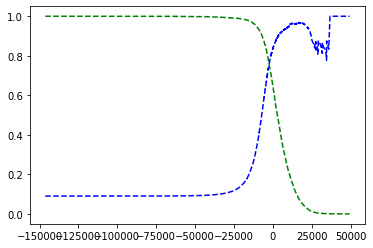

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1],"g--",label='재현율')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

- 정밀도 곡선이 재현율 곡선보다 울퉁불퉁한 이유
  - 임곗값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문(일반적으로 높아져야 함)

- 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작
  - 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음(약 60%정도)



In [26]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439557

- (훈련 세트에 대한) 예측을 만들려면 분류기의 predict() 메서드를 호출하는 대신 다음 코드 실행

In [27]:
y_train_pred_90=(y_scores >= threshold_90_precision)

In [28]:
#정밀도와 재현율 확인
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

###**3.3.5 ROC 곡선**
수신기 조작 특성(ROC) 곡선 : 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선

In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

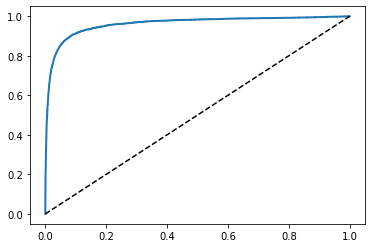

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') #대각 점선
  
plot_roc_curve(fpr, tpr)
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [36]:
y_scores_forest=y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5, y_scores_forest)

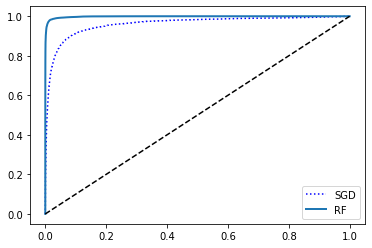

In [37]:
#이제 ROC 그려보자. 비교를 위해 첫번째 ROC도 그리자.
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'RF')
plt.legend(loc='lower right')
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

##**3.4 다중분류**